# Feature Creation

### All Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, HTML, Markdown
from glob import glob
from word_list.basic import politics1, politics2
from word_list.basic import business, preis, huang
from statsmodels.tsa.stattools import adfuller

In [2]:
base_daily_dfs_paths = glob("data/all_daily_trends/*")
base_daily_dfs_paths.sort()

## Organizing Google trends data

In [3]:
def create_gtrends_data_using_base_path(base_path):
    trends_path = os.path.join(base_path,"*.csv")
    daily_dfs_path =  glob(trends_path)
    daily_dfs_path.sort()
    daily_dfs = [pd.read_csv(path) for path in daily_dfs_path]
    daily_dfs_names = [i.split("/")[3] for i in daily_dfs_path]
    daily_dfs_names = [i.split(".")[0] for i in daily_dfs_names]

    trends_list = []
    for name, df in zip(daily_dfs_names, daily_dfs):
        df.index = pd.to_datetime(df.date)
        ts = df[name]
        new_name = name.replace(" ", "_")
        ts.name = name
        trends_list.append(ts)

    trends = pd.concat(trends_list,1)
    trends = trends.fillna(0.0)

    columns = list(trends.columns)

    assert [c for c in huang if c not in preis] == []
    assert [c for c in preis if c not in columns] == []
    assert [c for c in huang if c not in columns] == []
    assert [c for c in politics1 if c not in columns] == []
    assert [c for c in politics2 if c not in columns] == []
    assert [c for c in business if c not in columns] == []

    selected_words = politics1 + politics2 + business + preis
    selected_words = list(set(selected_words))
    selected_words.sort()
    if trends.notability.max() == 0:
        selected_words.remove("notability")
    trends = trends[selected_words]
    trends = trends[:"2020-12-31"]
    return trends


In [4]:
df_list = [create_gtrends_data_using_base_path(p) for p in base_daily_dfs_paths]


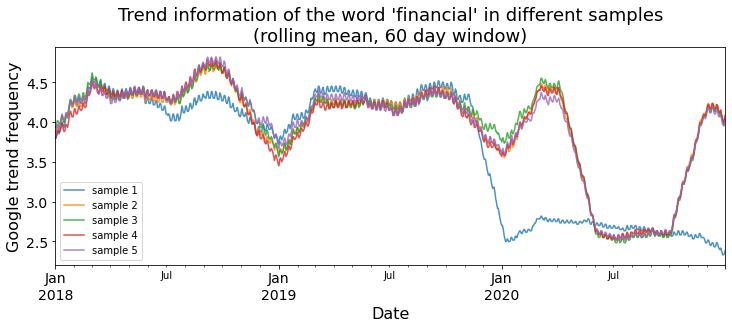

In [11]:
word = "financial"
window = 60
cut = [df[word] for df in df_list]

ex = pd.concat(cut,1)
ex.columns = ["sample {}".format(i+1) for i in range(len(cut))]
fig, ax = plt.subplots(figsize=(12,4))
ex.rolling(window).mean()["2018-01-01":].plot(ax=ax,legend=True, alpha=0.8);
title = "Trend information of the word '{}' in different samples".format(word)
title += "\n(rolling mean, {} day window)".format(window)
ax.set_title(title, fontsize=18);
ax.set_ylabel("Google trend frequency", fontsize=16);
ax.set_xlabel("Date", fontsize=16);
ax.tick_params(axis="x", labelsize=14);
ax.tick_params(axis="y", labelsize=14);
ax.legend(loc="best");
fig.savefig('img/gtrends_samples.png',  bbox_inches='tight')

In [6]:
cut = [df[word] for df in df_list]
ex = pd.concat(cut,1)

In [7]:
ex.head(3)

,financial,financial,financial,financial,financial
date,,,,,
2004-01-01,16.0,16.0,17.0,16.0,15.0
2004-01-02,31.0,25.0,33.0,33.0,31.0
2004-01-03,14.0,18.0,15.0,25.0,17.0


In [8]:
ex.median(1)

date
2004-01-01    16.0
2004-01-02    31.0
2004-01-03    17.0
2004-01-04    16.0
2004-01-05    20.0
              ... 
2020-12-27     2.0
2020-12-28     4.0
2020-12-29     4.0
2020-12-30     5.0
2020-12-31     4.0
Length: 6210, dtype: float64

In [10]:
np.median([16.0, 16.0, 17.0, 16.0, 15.0])

16.0

In [9]:
fsfsfsfsff

NameError: name 'fsfsfsfsff' is not defined

## Creating Features

Let ${S^{w}}_t$ be the search interest in the word $w$ at day $t$, we define the word feature ${D^{w}}_t$ as the first difference:

\begin{equation}
{D^{w}}_{t} = {S^{w}}_t - {S^{w}}_{t-1}.
\end{equation}

### Sanity Check 3

In [ ]:
alpha = 0.01
diff_param = 1
obs = []
for c in tqdm(trends.columns):
    s = trends[c].diff(diff_param).dropna().values
    result_adfuller = adfuller(s)
    p_value = result_adfuller[1]
    obs.append((c, p_value, p_value < alpha))
    
obs = pd.DataFrame(obs, columns=["column","p_value","test"])
assert np.all(obs["test"])

### DataFrame with first differences only

In [ ]:
trends = trends.diff(1).dropna()
trends.head(5)

In [ ]:
trends.tail(5)

In [ ]:
trends.shape

### Saving

In [ ]:
path = os.path.join("data", "gtrends.csv")
trends.to_csv(path)

### Checking correlation

In [ ]:
corr_preis = trends[preis].corr().values.flatten()
corr_preis = np.unique(corr_preis)
corr_curme = trends[curme].corr().values.flatten()
corr_curme = np.unique(corr_curme)
corr = trends.corr().values.flatten()
corr = np.unique(corr)
m = np.max([corr_preis.shape[0], corr_curme.shape[0], corr.shape[0]])
corr_preis  = np.append(corr_preis, np.repeat(np.nan, m - corr_preis.shape[0]))
corr_curme  = np.append(corr_curme, np.repeat(np.nan, m - corr_curme.shape[0]))
corr  = np.append(corr, np.repeat(np.nan, m - corr.shape[0]))
corr_df = pd.DataFrame({"Preis' Features":corr_preis, "Curme's Features":corr_curme})

factor = 1.3
fig, ax = plt.subplots(figsize=(10*factor, 5*factor))
sns.boxplot(data=corr_df, orient="v", palette="Set2", ax=ax)
plt.yticks(fontsize=12);
ax.set_ylabel("Correlation", fontsize=14)
plt.xticks(fontsize=14);